In [10]:
import graphviz
import pandas as pd
import math

data = pd.read_csv('sample_data/titanic-homework.csv').drop(columns=['PassengerId', 'Name'])
label = 'Survived'
X = data[list(set(data.columns) - {label})]
y = data[label]


In [11]:
def e(lst):
    p = 0
    for x in lst:
        if x:
            p -= x * math.log2(x)
    return p

def calculate_entropy(S):
    unique_values = pd.Series(S).unique()
    probabilities = []
    for value in unique_values:
        probability = (S == value).mean()
        probabilities.append(probability)
    return e(probabilities)

def calculate_conditional_entropy(S, A): #entropia warunkowa
    S_series = pd.Series(S)
    A_series = pd.Series(A)
    conditional_entropy_value = 0
    for unique_value in S_series.unique():
        mask = S_series == unique_value
        prob = mask.mean()
        conditional_entropy_value += prob * calculate_entropy(A_series[mask])
    return conditional_entropy_value

def calculate_gain_ratio(S, A):
    gain = calculate_entropy(A) - calculate_conditional_entropy(S, A)
    info = calculate_entropy(S)
    if info != 0:
      return gain / info
    return gain

def find_split_points(X, y):
    pairs = sorted(zip(X, y), key=lambda x: x[0])
    last_value, last_label = pairs[0]
    split_values = []
    for value, label in pairs[1:]:
        if last_label != label:
            split_point = (last_value + value) / 2
            split_values.append(split_point)
            last_label = label
        last_value = value
    return split_values

def find_best_split_column(X, y, numerical):
    best_column_data = []
    for column in X.columns:
        if column in numerical:
            for split in find_split_points(X[column], y):
                X_split = X[column].apply(lambda val: f'<{split}' if val < split else f'>={split}')
                score = calculate_gain_ratio(X_split, y)
                best_column_data.append((column, score, split, X_split))
        else:
            score = calculate_gain_ratio(X[column], y)
            best_column_data.append((column, score, None, X[column]))
    return max(best_column_data, key=lambda item: item[1])

def id3_algorithm(X, y, numerical=[]):
    if len(y.unique()) == 1:
        return (str(y.iloc[0]), [])
    if len(X.columns) == 0:
        counts = ', '.join(f'{label} ({count})' for label, count in y.value_counts().items())
        return (counts, [])

    best, score, split, X_best = find_best_split_column(X, y, numerical)
    nodes = []
    for value in X_best.unique():
        mask = X_best == value
        filtered_columns = list(X.columns)
        child_node = id3_algorithm(X.loc[mask, filtered_columns], y[mask], numerical)
        nodes.append((value, child_node))
    return (best, nodes)

def visualize_decision_tree(tree):
    def draw_tree_rec(tree, path=[]):
        name, nodes = tree
        current_path = '/'.join(path)
        dot.node(current_path, label=name, color='red' if not nodes else None)
        for value, node in nodes:
            next_path = path + [name, f'{value}']
            child_path = '/'.join(next_path)
            dot.edge(current_path, child_path, label=f'{value}')
            draw_tree_rec(node, next_path)

    dot = graphviz.Digraph()
    dot.format = 'jpeg'
    draw_tree_rec(tree)
    return dot


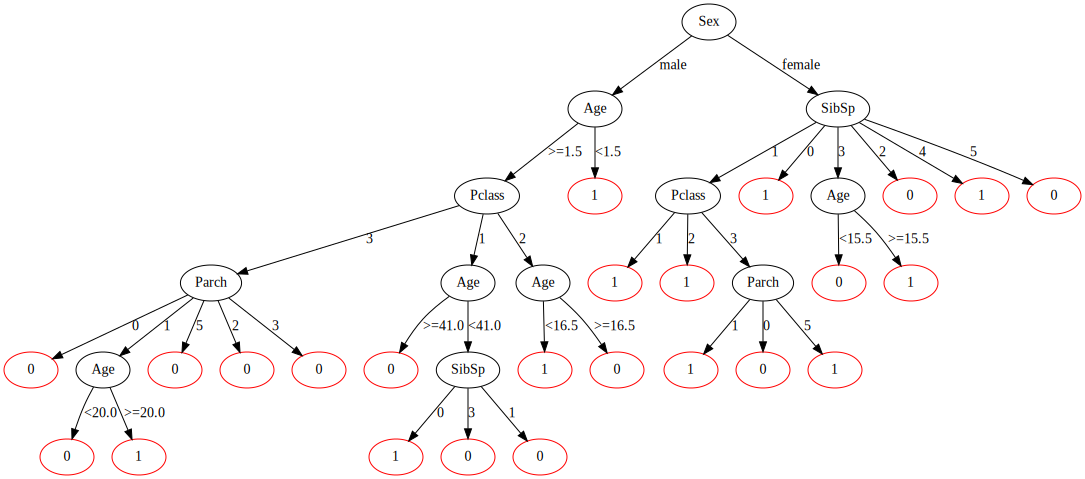

In [15]:
visualize_decision_tree(id3_algorithm(X, y, numerical=['Age']))